In [1]:
import torch
import torch.nn as nn
from torch.nn.functional import mse_loss
import torch.optim as optim

import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.models import VGG19_Weights

from PIL import Image
import matplotlib.pyplot as plt

### Global Variables

In [2]:
device = torch.device(
    "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
torch.set_default_device(device)
img_width = 1024
img_height = 1024
original_img_size = (img_width, img_height)

### Load Images

In [3]:
def image_loader(style_path, content_path, use_fixed_size=False):
    global img_width, img_height, original_img_size

    style_image = Image.open(style_path)
    content_image = Image.open(content_path)

    width1, height1 = style_image.size
    width2, height2 = content_image.size
    original_img_size = (width2, height2)

    if not use_fixed_size:
        img_width = min(width1, width2)
        img_height = min(height1, height2)

    transform = transforms.Compose(
        [transforms.Resize((img_height, img_width)), transforms.ToTensor()])
    style_image = transform(style_image).unsqueeze(0)
    content_image = transform(content_image).unsqueeze(0)

    return style_image.to(device, torch.float), content_image.to(device,
                                                                 torch.float)


def image_display(tensor, title=None, size=None, save=False):
    plt.figure()
    transform = transforms.ToPILImage()

    img = tensor.cpu().clone()
    img = img.squeeze(0)
    img = transform(img)

    if size:
        img = img.resize(size)
    plt.imshow(img)

    if save:
        img.save(f'{title}.jpg')

    if title:
        plt.title(title)
    plt.pause(0.001)

### Content Loss

In [4]:
class ContentLoss(nn.Module):
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target.clone().detach()
        self.loss = None

    def forward(self, input):
        self.loss = mse_loss(input, self.target)
        return input

### Style Loss

In [5]:
def gram_matrix(input):
    a, b, c, d = input.size()
    features = input.view(a * b, c * d)
    G = torch.mm(features, features.t())
    return G.div(a * b * c * d)


class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).clone().detach()
        self.loss = None

    def forward(self, input):
        self.loss = mse_loss(gram_matrix(input), self.target)
        return input

### Normalization

In [6]:
class Normalization(nn.Module):
    def __init__(self):
        super(Normalization, self).__init__()

        cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406])
        cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225])

        self.mean = torch.tensor(cnn_normalization_mean).view(-1, 1, 1)
        self.std = torch.tensor(cnn_normalization_std).view(-1, 1, 1)

    def forward(self, img):
        return (img - self.mean) / self.std

In [7]:
content_layers_default = ['relu_10']
style_layers_default = ['relu_1', 'relu_3', 'relu_5', 'relu_9', 'relu_13']


def get_model_styleLoss_contentLosses(vgg19, target_style_img,
                                      target_content_img,
                                      content_layers=content_layers_default,
                                      style_layers=style_layers_default):
    normalization = Normalization()
    content_losses = []
    style_losses = []

    model = nn.Sequential(normalization)

    i = 0
    for layer in vgg19.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            layer = nn.ReLU(inplace=False)  # In place ReLU does not work well
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError(
                'Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            target = model(target_content_img).clone().detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            target_feature = model(target_style_img).clone().detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # Remove layers after the last content and style losses layers
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

In [8]:
def start_NST(vgg19, optimizer, content_img, style_img, input_img,
              num_steps=300, style_weight=1000000, content_weight=1,
              learning_rate=0.01, momentum=0.9, weight_decay=0.0001, steps=10):

    NST, style_losses, content_losses = get_model_styleLoss_contentLosses(vgg19,
                                                                          style_img,
                                                                          content_img)

    input_img.requires_grad_(True)
    NST.eval()
    NST.requires_grad_(False)

    assert optimizer in ("sgd", "adam", "lbfgs")

    if optimizer == "sgd":
        optimizer = optim.SGD(NST.parameters(),
                              lr=learning_rate,
                              momentum=momentum,
                              weight_decay=weight_decay)
    elif optimizer == "adam":
        optimizer = optim.Adam(NST.parameters(), lr=learning_rate)

    elif optimizer == "lbfgs":
        optimizer = optim.LBFGS([input_img])

    run = [0]
    while run[0] <= num_steps:

        def closure():
            # Not calculate the gradients, and the program explicitly uses it here (as with most neural networks) in order to not update the gradients when it is updating the weights as that would affect the back propagation.
            with torch.no_grad():
                # ensure that the pixel values of the generated image (input_img) are within the valid range [0, 1] since when you use the transforms.ToTensor() transformation in torchvision, it automatically converts the pixel values from [0, 255] to [0, 1] by dividing each pixel value by 255.
                input_img.clamp_(0, 1)

            optimizer.zero_grad()
            NST(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % steps == 0:
                print('Step: {} Style Loss : {:4f} Content Loss: {:4f}'.format(
                    run[0], style_score.item(), content_score.item()))

            return style_score + content_score

        optimizer.step(closure)

    with torch.no_grad():
        input_img.clamp_(0, 1)

    return input_img

Width: 454, Height: 300


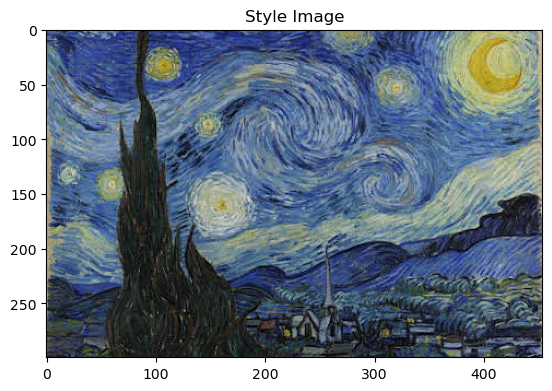

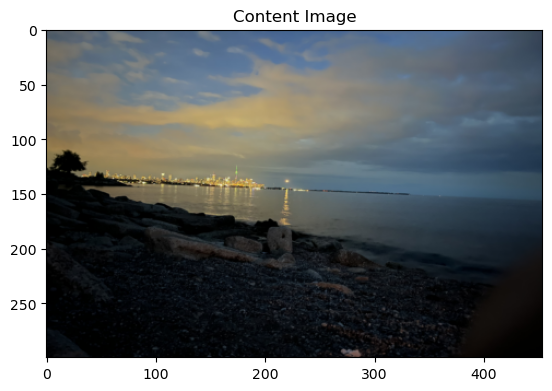

Step: 10 Style Loss : 17.732750 Content Loss: 3.704890
Step: 20 Style Loss : 6.216616 Content Loss: 3.133879
Step: 30 Style Loss : 3.415757 Content Loss: 2.770011
Step: 40 Style Loss : 2.219218 Content Loss: 2.454654
Step: 50 Style Loss : 1.751447 Content Loss: 2.265613
Step: 60 Style Loss : 1.535420 Content Loss: 2.119836
Step: 70 Style Loss : 1.395305 Content Loss: 2.033771
Step: 80 Style Loss : 1.282770 Content Loss: 1.962390
Step: 90 Style Loss : 1.210292 Content Loss: 1.897758
Step: 100 Style Loss : 1.143460 Content Loss: 1.853544
Step: 110 Style Loss : 1.092452 Content Loss: 1.808203
Step: 120 Style Loss : 1.047544 Content Loss: 1.776729
Step: 130 Style Loss : 1.018246 Content Loss: 1.746574
Step: 140 Style Loss : 0.994099 Content Loss: 1.721289
Step: 150 Style Loss : 0.973052 Content Loss: 1.700505
Step: 160 Style Loss : 0.957127 Content Loss: 1.682824
Step: 170 Style Loss : 0.945239 Content Loss: 1.666401
Step: 180 Style Loss : 0.933542 Content Loss: 1.653144
Step: 190 Style Lo

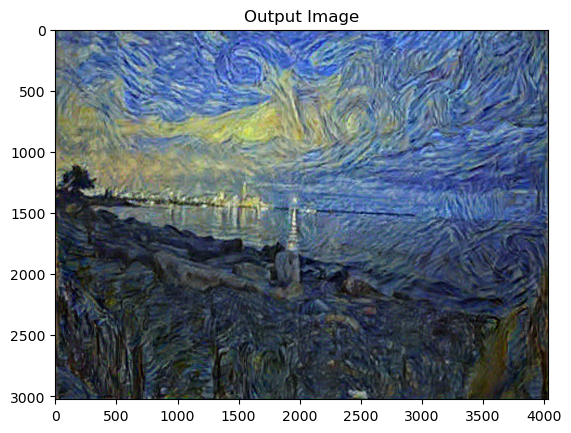

In [9]:
# Load pre-trained VGG19 model
vgg19 = models.vgg19(weights=VGG19_Weights.DEFAULT).features.eval()

# Load images and check image sizes
style_img, content_img = image_loader(style_path="./fangao.jpeg",
                                      content_path="./img3.jpeg")
input_img = content_img.clone()

assert style_img.size() == content_img.size()
print("Width: {}, Height: {}".format(img_width, img_height))

# Display images
plt.ion()
image_display(style_img, title='Style Image')
image_display(content_img, title='Content Image')

# Start training
output = start_NST(vgg19, optimizer="lbfgs", content_img=content_img,
                   style_img=style_img, input_img=input_img, num_steps=300,
                   style_weight=1000000)
image_display(output, title='Output Image', size=original_img_size)
plt.ioff()
plt.show()
